### Package Install

This doesn't need to be run every time.  The cell is set to "Raw", you'll need to change it to a "Code" or "Python" cell to execute it.

In [12]:
!pip install -q git+https://github.com/DataScienceUWL/DS776.git#subdirectory=introdl


# Object Detection of Pedestrians

In general object detection, **Mean Average Precision (mAP)** is a key metric for evaluating how well a model identifies and localizes multiple object types within an image. Here are the core concepts:

### Key Concepts of mAP for Object Detection

1. **Intersection over Union (IoU)**:
   - **IoU** measures the overlap between a predicted bounding box and the ground truth bounding box. It is calculated as:
     \[
     \text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}
     \]
   - IoU values range from 0 to 1, where values closer to 1 indicate a high overlap, meaning the prediction closely matches the ground truth. IoU thresholds, often 0.5 and 0.75, determine the minimum overlap required for a correct detection.

2. **True Positives (TP), False Positives (FP), and False Negatives (FN)**:
   - A **True Positive** occurs when a predicted bounding box matches a ground truth box with IoU above the threshold.
   - A **False Positive** occurs when a predicted box does not match any ground truth box (IoU below threshold) or detects a non-existent object.
   - A **False Negative** occurs when a ground truth box has no matching predicted box, indicating the model missed detecting an actual object.

3. **Precision and Recall**:
   - **Precision** measures how many of the detected objects are correct, calculated as:
     \[
     \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
     \]
   - **Recall** measures how many actual objects the model detected, calculated as:
     \[
     \text{Recall} = \frac{\text{TP}}{\text{TP + FN}}
     \]
   - Precision and Recall are typically calculated at multiple IoU thresholds (e.g., 0.5, 0.75) to reflect different levels of localization accuracy.

4. **Precision-Recall Curve and Average Precision (AP)**:
   - For each IoU threshold, a **Precision-Recall curve** is plotted by varying the confidence threshold of detections.
   - The **Average Precision (AP)** at each IoU threshold is the area under the Precision-Recall curve, providing a measure of the model’s accuracy at that IoU level.

5. **Mean Average Precision (mAP)**:
   - **mAP** is the mean of AP values across multiple IoU thresholds and classes.
   - In multi-class detection, mAP averages AP across both classes and IoU thresholds, providing a single score representing the model’s overall detection and localization performance across object types.

### Applying mAP to One-Class Detection Problems
In a single-class object detection task (e.g., detecting pedestrians or lesions), mAP still measures localization accuracy and detection reliability but focuses on just one object type. Here’s how mAP applies specifically to single-class detection:

- **Simplified IoU Thresholds**: For single-class problems, a single IoU threshold (e.g., 0.5) can suffice. This is known as mAP@0.5 and indicates the model’s accuracy in detecting and localizing objects of that class at a moderate level of overlap.
- **Single Precision-Recall Curve**: Instead of averaging AP across classes, a single Precision-Recall curve is created for the one object class. The AP value from this curve reflects the model’s detection accuracy for the class.
- **Interpretability**: A higher mAP score (closer to 1) means the model consistently detects and localizes instances of the single class with minimal false positives and missed detections, simplifying performance interpretation compared to multi-class problems.

**Intuitive Explanation for mAP:**

mAP, or mean Average Precision, measures how well a model detects objects by considering both **precision** (accuracy of predictions) and **recall** (coverage of ground truth objects). In essence, mAP tells you how well the model balances detecting **all instances** of an object while also keeping **false positives** (incorrect detections) low.

In a single-class problem, mAP captures how accurately and consistently the model detects objects of that class across different confidence thresholds. A high mAP means the model is good at finding and correctly classifying instances of the object.

**What mAP@50 and mAP@50:95 Mean for a Single-Class Problem:**

- **mAP@50**: This calculates the model's precision and recall at an Intersection over Union (IoU) threshold of 0.5. In simpler terms, a detection counts as correct if it overlaps with the ground truth by at least 50%. So, mAP@50 measures the model's ability to find objects without being overly strict about the exact position and size of the bounding box.

- **mAP@50:95**: This is a stricter metric that averages the mAP across IoU thresholds from 0.5 to 0.95 in steps of 0.05 (0.5, 0.55, …, 0.95). Here, the model needs to get closer to the actual object boundary to achieve a high score, making mAP@50:95 a more challenging but comprehensive measure of detection accuracy. It requires the model not just to detect objects but also to have precise bounding box localization.

In a single-class problem, mAP@50 gives a good indication of basic detection performance, while mAP@50:95 is more demanding and reflects both detection and precise localization quality.

In [6]:
import json
from pathlib import Path

# Load JSON config file
with open("../config.json", "r") as f:
    config = json.load(f)

# Convert paths to Path objects using pathlib
MODELS_PATH = Path(config["MODELS_PATH"])
DATA_PATH = Path(config["DATA_PATH"])
TORCH_HOME = Path(config["TORCH_HOME"])

import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

import torch
from pathlib import Path
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
import torchvision.transforms.v2 as T
import random
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision import tv_tensors


import torch.optim as optim
from torchmetrics.detection.mean_ap import MeanAveragePrecision


from graphics_and_data_prep import display_images_and_boxes


In [ ]:
class PennFudanDetect(Dataset):
    """
    Custom Dataset for Penn-Fudan Database for Pedestrian Detection and Segmentation.
    Args:
        root (str or Path): Root directory of the dataset.
        transforms (callable, optional): A function/transform that takes in an image and target and returns a transformed version.
        split (str, optional): Dataset split, either 'train' or 'val'. Default is 'train'.
        seed (int, optional): Random seed for shuffling the dataset. Default is 42.
    Attributes:
        imgs (list): List of image file paths.
        masks (list): List of mask file paths.
        split (str): Dataset split, either 'train' or 'val'.
        seed (int): Random seed for shuffling the dataset.
    Methods:
        __getitem__(idx):
            Args:
                idx (int): Index of the item to be fetched.
            Returns:
                tuple: (image, target) where target is a dictionary containing 'boxes' and 'labels'.
        __len__():
            Returns:
                int: Number of items in the dataset.
    """
    def __init__(self, root, transforms=None, split='train', seed=42):
        self.root = Path(root)
        self.transforms = transforms
        self.split = split
        self.seed = seed

        # Load all image and mask files
        imgs = sorted((self.root / "PNGImages").iterdir())
        masks = sorted((self.root / "PedMasks").iterdir())

        # Ensure reproducibility with a fixed seed
        indices = list(range(len(self.imgs)))
        train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

        # Assign the split based on the parameter
        if split == 'train':
            self.indices = train_indices
        elif split == 'val':
            self.indices = val_indices
        else:
            raise ValueError("Split must be 'train' or 'val'")
        
        # Subset the images and masks according to the split
        self.imgs = [imgs[i] for i in self.indices]
        self.masks = [masks[i] for i in self.indices]

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = read_image(str(img_path)).float() / 255.0  # Normalize to [0, 1]
        mask = read_image(str(mask_path))

        # Prepare masks and bounding boxes
        obj_ids = torch.unique(mask)[1:]  # Exclude background (first ID)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        boxes = masks_to_boxes(masks)
        labels = torch.ones((len(obj_ids),), dtype=torch.int64)  # Single class

        # Create tv_tensor types
        img = tv_tensors.Image(img)
        target = {
            "boxes": tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:]),
            "labels": labels,
        }

        # Apply transformations
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)


In [8]:
# Define training transformations
train_transforms = T.Compose([
    T.RandomHorizontalFlip(0.5),  # Random horizontal flip with 50% probability
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),  # Color jitter
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Define validation transformations (no data augmentation, just tensor conversion)
val_transforms = T.Compose([
    T.ToPureTensor()  # Convert to a standard torch.Tensor with normalization
])

# Usage with the dataset
dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
train_dataset = PennFudanDetect(root=dataset_path, split='train', transforms=train_transforms)
val_dataset = PennFudanDetect(root=dataset_path, split='val', transforms=val_transforms)

def collate_fn(batch):
    return tuple(zip(*batch))

# define training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

In [62]:
# model configuration
model_save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone_name = 'resnet50'  # Using ResNet-50 for better performance
weights = "DEFAULT"   # Use pretrained weights

# Initialize the Faster R-CNN model with a ResNet-50 backbone
backbone = resnet_fpn_backbone(backbone_name=backbone_name, weights=weights)
model = FasterRCNN(backbone, num_classes=2)

# Set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # MPS doesn't work with Faster R-CNN
model.to(device)

# training configuration
initial_lr = 0.005  # Initial learning rate
weight_decay = 0.0005
patience = 5  # Early stopping patience

# Training parameters
num_epochs = 15
patience = 3

# Optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)

# Initialize mAP metrics for validation
map_metric = MeanAveragePrecision(iou_thresholds=[0.5, 0.75])

# Function to train one epoch with optional validation
def train_one_epoch(model, optimizer, train_loader, val_loader, device):
    model.train()
    running_loss = 0.0
    
    # Training phase
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        
        running_loss += losses.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation phase
    model.eval()  # Switch to eval mode to get predictions
    val_running_loss = 0.0
    map_metric.reset()  # Reset metrics before validation

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Get model predictions without targets to avoid returning losses
            outputs = model(images)
            
            # Format outputs and targets for torchmetrics
            formatted_outputs = [
                {k: v.cpu() for k, v in output.items()} for output in outputs
            ]
            formatted_targets = [
                {k: (v.cpu() if isinstance(v, torch.Tensor) else v) for k, v in target.items()} for target in targets
            ]
            
            # Update mAP metric with formatted outputs and targets
            map_metric.update(formatted_outputs, formatted_targets)
            
            # Temporarily switch to training mode to compute validation loss
            model.train()
            loss_dict = model(images, targets)
            val_losses = sum(loss for loss in loss_dict.values())
            val_running_loss += val_losses.item()
            
            # Switch back to eval mode for the next prediction
            model.eval()

    # Calculate mAP metrics
    avg_val_loss = val_running_loss / len(val_loader)
    map_metrics = map_metric.compute()
    map_50 = map_metrics['map_50']
    map_50_95 = map_metrics['map']
    
    return avg_train_loss, avg_val_loss, map_50, map_50_95



# Early stopping setup
best_map_50_95 = 0.0
epochs_without_improvement = 0

for epoch in range(num_epochs):
    # Train and validate for the epoch
    avg_train_loss, avg_val_loss, map_50, map_50_95 = train_one_epoch(model, optimizer, train_loader, val_loader, device)
    
    epoch_str = (f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, "
                 f"Val Loss: {avg_val_loss:.4f}, mAP@50: {map_50:.4f}, mAP@50-95: {map_50_95:.4f}")

    # Check for improvement in mAP@50-95
    if map_50_95 > best_map_50_95:
        best_map_50_95 = map_50_95
        epochs_without_improvement = 0
        torch.save(model.state_dict(), model_save_path)
        epoch_str += " New best mAP@50-95. Model weights saved."
    else:
        epochs_without_improvement += 1

    print(epoch_str)

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs with no improvement in mAP@50-95.")
        break

    # Step the scheduler based on mAP@50-95
    scheduler.step(map_50)

# If training completes without early stopping, save the final model
if epochs_without_improvement < patience:
    torch.save(model.state_dict(), model_save_path)
    print(f"Training complete. Final model weights saved.")


Epoch [1/15], Train Loss: 0.3952, Val Loss: 0.3989, mAP@50: 0.3803, mAP@50-95: 0.2059 New best mAP@50-95. Model weights saved.
Epoch [2/15], Train Loss: 0.2471, Val Loss: 0.2687, mAP@50: 0.6119, mAP@50-95: 0.3475 New best mAP@50-95. Model weights saved.
Epoch [3/15], Train Loss: 0.1933, Val Loss: 0.2183, mAP@50: 0.8021, mAP@50-95: 0.5192 New best mAP@50-95. Model weights saved.
Epoch [4/15], Train Loss: 0.1694, Val Loss: 0.2108, mAP@50: 0.8689, mAP@50-95: 0.5868 New best mAP@50-95. Model weights saved.
Epoch [5/15], Train Loss: 0.1651, Val Loss: 0.1788, mAP@50: 0.9043, mAP@50-95: 0.7175 New best mAP@50-95. Model weights saved.
Epoch [6/15], Train Loss: 0.1491, Val Loss: 0.1855, mAP@50: 0.8936, mAP@50-95: 0.6744
Epoch [7/15], Train Loss: 0.1452, Val Loss: 0.1948, mAP@50: 0.9018, mAP@50-95: 0.7436 New best mAP@50-95. Model weights saved.
Epoch [8/15], Train Loss: 0.1458, Val Loss: 0.1954, mAP@50: 0.9150, mAP@50-95: 0.7373
Epoch [9/15], Train Loss: 0.1405, Val Loss: 0.2095, mAP@50: 0.9259

In [9]:

# Paths and training parameters
model_save_path = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone_name = 'resnet50'  # Using ResNet-50 for better performance
weights = "DEFAULT"   # Use pretrained weights

backbone = resnet_fpn_backbone(backbone_name=backbone_name, weights=weights)
model = FasterRCNN(backbone, num_classes=2)
model.load_state_dict(torch.load(model_save_path, map_location=torch.device('cpu'), weights_only=True));
model.eval();

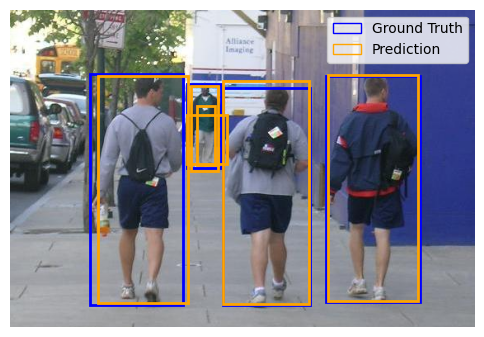

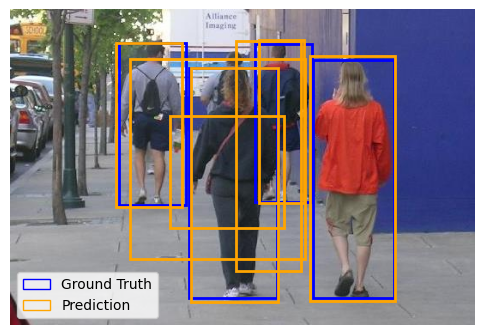

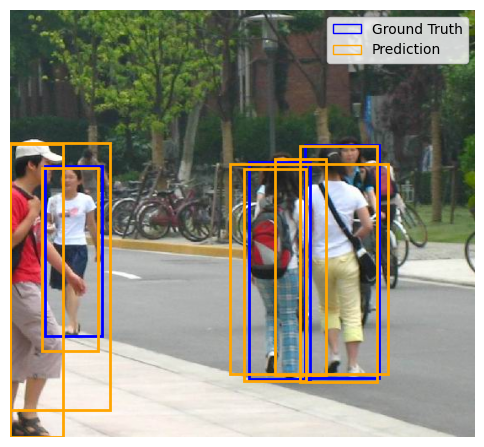

In [10]:
# Display random samples with ground truth and predictions with no filtering
selected_images = [0,4,6]
display_images_and_boxes(val_dataset, model=model, indices=selected_images,denormalize=False, confidence_threshold=0.0, iou_threshold=1.0)

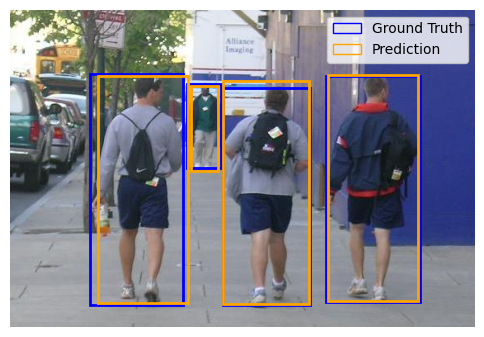

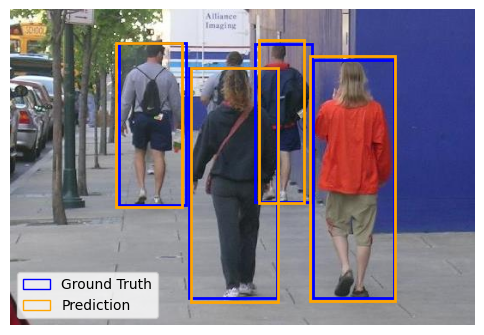

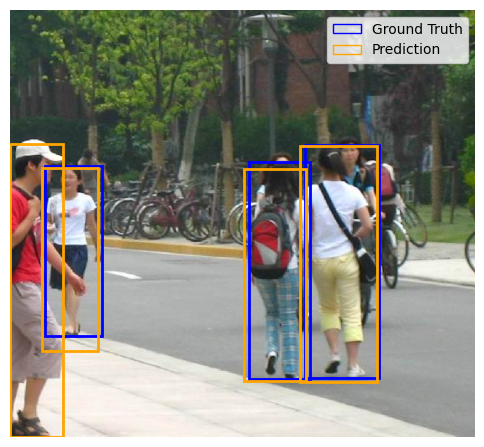

In [69]:
# Display random samples with ground truth and predictions with no filtering
display_images_and_boxes(val_dataset, model=model, indices=selected_images,denormalize=False)

In [ ]:
import torch
from pathlib import Path
from torchvision.io import read_image
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from torchvision.transforms import v2 as transforms  # Import v2 as transforms

class PennFudanSegment(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = Path(root)
        self.transforms = transforms
        # Load all image and mask files
        self.imgs = sorted((self.root / "PNGImages").iterdir())
        self.masks = sorted((self.root / "PedMasks").iterdir())

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]
        img = read_image(str(img_path)).float() / 255.0  # Ensure float type and normalize to [0, 1]
        mask = read_image(str(mask_path))

        # Combine all instance masks into a single binary mask
        combined_mask = (mask > 0).to(dtype=torch.uint8)  # Any non-zero value in mask becomes 1

        # Convert image and mask to tv_tensor types
        img = tv_tensors.Image(img)
        combined_mask = tv_tensors.Mask(combined_mask)

        # Apply transformations
        if self.transforms is not None:
            img, combined_mask = self.transforms(img, combined_mask)

        return img, combined_mask

    def __len__(self):
        return len(self.imgs)

# Define a transformation pipeline that includes resizing to 224x224
def get_transform(train):
    transforms_list = []
    # Resize all images and masks to 224x224
    transforms_list.append(transforms.Resize((224, 224)))
    
    if train:
        transforms_list.append(transforms.RandomHorizontalFlip(0.5))  # Random horizontal flip with 50% probability
        transforms_list.append(transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1))  # Color jitter
        transforms_list.append(transforms.RandomRotation(degrees=(-10, 10)))  # Random rotation within +/- 10 degrees
        transforms_list.append(transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)))  # Apply Gaussian blur
    
    # Convert to a standard torch.Tensor with normalization
    transforms_list.append(transforms.ToPureTensor())
    
    return transforms.Compose(transforms_list)

# Usage with the dataset
dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
train_dataset = PennFudanDataset(root=dataset_path, transforms=get_transform(train=True))
val_dataset = PennFudanDataset(root=dataset_path, transforms=get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
val_dataset_ = torch.utils.data.Subset(val_dataset, indices[-50:])

# Define the collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Define training and validation data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=collate_fn
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)
